## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random

%env CUDA_VISIBLE_DEVICES=0
import torch
import torchvision as tv
from torchvision import datasets, transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#import torch_dip_utils as utils
import math

import time

import pywt

env: CUDA_VISIBLE_DEVICES=0


## Network parameters, Waveform parameters

In [2]:
#set up hyperparameters, net input/output sizes, and whether the problem is compressed sensing

LR = 1e-3 # learning rate
MOM = 0.9 # momentum
NUM_ITER = 200 # number iterations
WD = 1e-4 # weight decay for l2-regularization
TV = 1e-1 # total variation regularisation 

Z_NUM = 32 # input seed dimension
NGF = 64 # number of filters per layer
NC = 1 # number of channels

## Signal Parameters

In [3]:
LENGTH = 1024
WAVE_PERIODS = 2
NUM_HARMONICS = 5

## Prediction: Define number of samples to keep 

In [4]:
NUM_MEASUREMENTS = 768

## Use CUDA if available

In [5]:
CUDA = torch.cuda.is_available()
print(CUDA)

#save the correct datatype depending on CPU or GPU execution
if CUDA : 
    dtype = torch.cuda.FloatTensor  
    print(torch.cuda.device(0))
else:
    dtype = torch.FloatTensor
    print("NO DEVICES")

True


## Define Method to create waveforms

In [6]:
#Produces a sinusoid with optional additive gaussian noise distributed (mean, std)
def get_sinusoid(num_samples, num_periods, num_harmonics = 1, noisy = True, std = 0.5, mean = 0):

    Fs = num_samples
    x = np.arange(num_samples)

    y = np.zeros((num_samples, 1))

    for i in range(num_harmonics):
        y[:, 0] += np.sin(2 * np.pi * (2**i) * num_periods * x / Fs)

    if noisy:
        y[:, 0] += (std * np.random.randn(num_samples)) + mean

    return y

## Create Training Waveform and plot

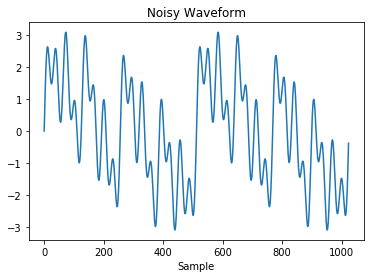

In [7]:
#create noisy (training) and de-noised (reference) waveforms
y0 = get_sinusoid(num_samples = LENGTH, num_periods = WAVE_PERIODS, num_harmonics = NUM_HARMONICS, noisy=False)
              
plt.figure()
plt.plot(np.arange(LENGTH), y0)
plt.xlabel("Sample")
plt.title("Noisy Waveform")
plt.show()

## Define Normalisation 

In [8]:
def normalise(x):
    y = np.squeeze(x)
    
    mins = np.min(y)
    maxs = np.max(y)
    ranges = maxs - mins
    
    return 2 * (x - mins)/ranges - 1

## Prepare waveform

In [9]:
y0_normalised = normalise(y0) # the training signal normalised to [-1,1]

#create a torch tensor of the measurements
meas = y0_normalised[0:NUM_MEASUREMENTS] 
y = torch.Tensor(meas)
y = Variable(y.type(dtype))

## Define Network Architecture

In [11]:
class DCGAN(nn.Module):
    def __init__(self, nz, ngf=64, output_size=1024, nc=1, num_measurements=64):
        super(DCGAN, self).__init__()
        self.nc = nc
        self.output_size = output_size

        # Deconv Layers: (in_channels, out_channels, kernel_size, stride, padding, bias = false)
        # Inputs: R^(N x Cin x Lin), Outputs: R^(N, Cout, Lout) s.t. Lout = (Lin - 1)*stride - 2*padding + kernel_size

        self.conv1 = nn.ConvTranspose1d(nz, ngf, 4, 1, 0, bias=False)
        self.bn1 = nn.BatchNorm1d(ngf)
        # LAYER 1: input: (random) zϵR^(nzx1), output: x1ϵR^(64x4) (channels x length)

        self.conv2 = nn.ConvTranspose1d(ngf, ngf, 6, 2, 2, bias=False)
        self.bn2 = nn.BatchNorm1d(ngf)
        # LAYER 2: input: x1ϵR^(64x4), output: x2ϵR^(64x8) (channels x length)

        self.conv3 = nn.ConvTranspose1d(ngf, ngf, 6, 2, 2, bias=False)
        self.bn3 = nn.BatchNorm1d(ngf)
        # LAYER 3: input: x1ϵR^(64x8), output: x2ϵR^(64x16) (channels x length)

        self.conv4 = nn.ConvTranspose1d(ngf, ngf, 6, 2, 2, bias=False)
        self.bn4 = nn.BatchNorm1d(ngf)
        # LAYER 4: input: x1ϵR^(64x16), output: x2ϵR^(64x32) (channels x length)

        self.conv5 = nn.ConvTranspose1d(ngf, ngf, 6, 2, 2, bias=False)
        self.bn5 = nn.BatchNorm1d(ngf)
        # LAYER 5: input: x2ϵR^(64x32), output: x3ϵR^(64x64) (channels x length)

        self.conv6 = nn.ConvTranspose1d(ngf, ngf, 6, 2, 2, bias=False)
        self.bn6 = nn.BatchNorm1d(ngf)
        # LAYER 6: input: x3ϵR^(64x64), output: x4ϵR^(64x128) (channels x length)

        self.conv7 = nn.ConvTranspose1d(ngf, ngf, 6, 2, 2, bias=False)
        self.bn7 = nn.BatchNorm1d(ngf)
        # LAYER 7: input: x4ϵR^(64x128), output: x5ϵR^(64x256) (channels x length)

        self.conv8 = nn.ConvTranspose1d(ngf, ngf, 6, 2, 2, bias=False)
        self.bn8 = nn.BatchNorm1d(ngf)
        # LAYER 8: input: x5ϵR^(64x256), output: x6ϵR^(64x512) (channels x length)

        self.conv9 = nn.ConvTranspose1d(ngf, nc, 4, 2, 1, bias=False)  # output is image
        # LAYER 9: input: x6ϵR^(64x512), output: (sinusoid) G(z,w)ϵR^(1x1024) (channels x length)

        self.fc = nn.Linear(output_size * nc, num_measurements, bias=False)  # output is A; measurement matrix
        # each entry should be drawn from a Gaussian (random noisy measurements)
        # don't compute gradient of self.fc! memory issues

    def forward(self, x):
        input_size = x.size()
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = F.relu(self.bn7(self.conv7(x)))
        x = F.relu(self.bn8(self.conv8(x)))
        x = F.tanh(self.conv9(x))

        return x

    def measurements(self, x):
        # this gives the image - make it a single row vector of appropriate length
        y = self.forward(x).view(1, -1)
        y = y.cpu()

        # pass thru FC layer - returns A*image
        meas = self.fc(y)

        if CUDA:
            return meas.cuda()
        else:
            return meas

## Initialise The network, random input, and FC layer

In [ ]:
net = DCGAN(Z_NUM, NGF, LENGTH, NC, num_measurements) # initialize network
net.fc.requires_grad = False

if CUDA: # move network to GPU if available
    net.cuda()
    print("USING CUDA")
else:
    print("RUNNING ON CPU")